In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Flatten, Dense, Reshape, BatchNormalization, UpSampling2D, concatenate, MaxPooling2D,Add,Embedding,Concatenate,Dropout,multiply,InputLayer,Conv2DTranspose,GlobalMaxPooling2D
from tensorflow.keras.models import Model,Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2,ResNet50V2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# System libraries
from pathlib import Path
import os.path
import time
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools


In [2]:
SIZE = 128


def get_dataset(dataset):
    X = []
    y = []

    image_dir = Path(dataset)
    print(image_dir)
    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.png'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    for file in filepaths[:]:
        
        img = Image.open(file).resize((SIZE,SIZE))
        img_rgb = img.convert('RGB')
        img = np.asarray(img_rgb) / 255.0

        X.append(img)
    for label in labels:
        y.append(label)


    return X,y
image_dir = 'D:\\Private\\CODE\\kaggle\\image_colorization\\new_data'
X, y = get_dataset(image_dir)


D:\Private\CODE\kaggle\image_colorization\new_data


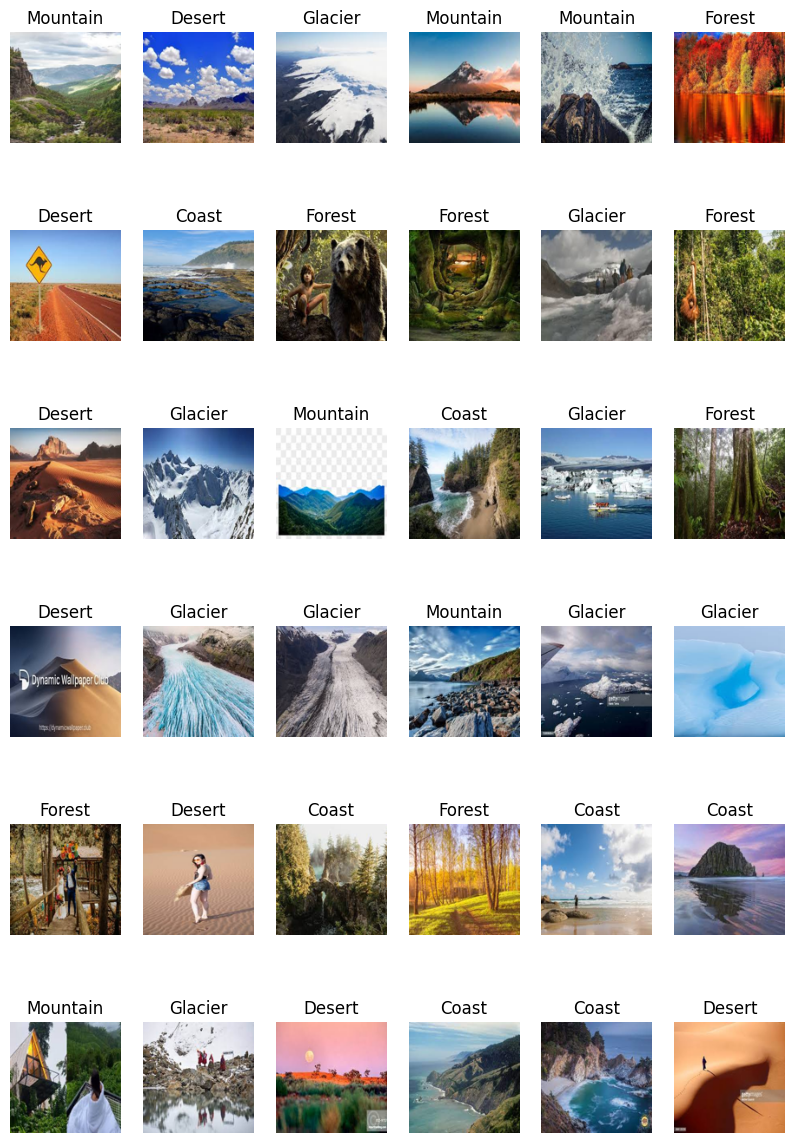

In [3]:
plt.figure(figsize=(10, 15))
for n, i in enumerate(np.random.randint(0, len(X), 36)):
    plt.subplot(6, 6, n + 1)
    
    # Convert array to uint8 format
    img_array = (X[i] * 255).astype(np.uint8) if X[i].dtype != np.uint8 else X[i]
    
    # Convert to Image object
    img_pil = Image.fromarray(img_array)
    plt.imshow(img_pil)
    plt.axis('off')
    plt.title(y[i]) 
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size = 0.2, random_state=42)

In [5]:
# Encode labels
encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

y_train = to_categorical(y_train, len(encoder.classes_))
y_test = to_categorical(y_test, len(encoder.classes_))


In [6]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (8125, 128, 128, 3)
y_train shape: (8125, 5)
X_test shape: (2032, 128, 128, 3)
y_test shape: (2032, 5)


In [7]:
num_classes = len(encoder.classes_)
labels = encoder.classes_ 
labels

array(['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain'], dtype='<U8')

In [8]:
# def create_model():

#     base_model = ResNet50V2(weights='imagenet', input_shape= ( SIZE,SIZE,3),pooling='max', classes=labels, include_top=False )

#     for layer in base_model.layers:
#         layer.trainable = False

#     model = Sequential()
#     model.add(base_model)
#     model.add(Flatten())

#     model.add(Dense(256,activation = 'relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(128,activation = 'relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(64,activation = 'relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(16,activation = 'relu'))
#     model.add(Dense(num_classes, activation = 'sigmoid'))
#     model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
#     return model

# model = create_model()
# model.summary()

In [14]:
def create_model():

    base_model = MobileNetV2(weights='imagenet', input_shape= ( 128,128,3),pooling='average', classes=labels, include_top=False )

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())

    model.add(Dense(128,activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64,activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16,activation = 'relu'))
    model.add(Dense(num_classes, activation = 'softmax'))
    model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               2621568   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

In [15]:
with tf.device('/gpu:0'):
    history = model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
508/508 [==============================] - 17s 26ms/step - loss: 1.1883 - accuracy: 0.5761 - val_loss: 0.6886 - val_accuracy: 0.7717
Epoch 2/50
508/508 [==============================] - 12s 24ms/step - loss: 0.7596 - accuracy: 0.7354 - val_loss: 0.6351 - val_accuracy: 0.7908
Epoch 3/50
508/508 [==============================] - 10s 20ms/step - loss: 0.6251 - accuracy: 0.7871 - val_loss: 0.6161 - val_accuracy: 0.7923
Epoch 4/50
508/508 [==============================] - 10s 20ms/step - loss: 0.5290 - accuracy: 0.8167 - val_loss: 0.5681 - val_accuracy: 0.8017
Epoch 5/50
508/508 [==============================] - 14s 28ms/step - loss: 0.4724 - accuracy: 0.8361 - val_loss: 0.5536 - val_accuracy: 0.8204
Epoch 6/50
508/508 [==============================] - 14s 28ms/step - loss: 0.4202 - accuracy: 0.8540 - val_loss: 0.5655 - val_accuracy: 0.8263
Epoch 7/50
508/508 [==============================] - 19s 37ms/step - loss: 0.3641 - accuracy: 0.8671 - val_loss: 0.5699 - val_accuracy:

In [2]:
# model.save('./save_model/prediction/model.keras')
model = tf.keras.models.load_model("D:\\Private\\CODE\\kaggle\\image_colorization\\save_model\\prediction\\model.keras")


In [4]:

labels = ['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']


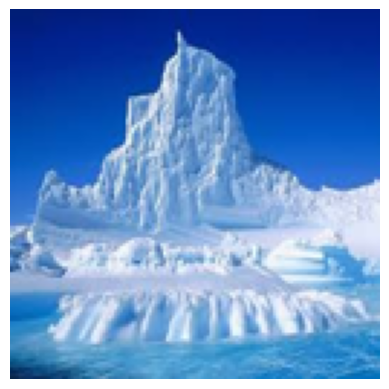

1/1 [==============================] - 0s 68ms/step
Predicted Class: Glacier


In [7]:
test_image = 'D:\\Private\\CODE\\kaggle\\image_colorization\\Test image\\tải xuống (3).jpg'
def prepare_image(image_path):
    img = Image.open(image_path).resize((128, 128))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    plt.imshow(img)
    plt.axis('off')  
    plt.show() 
    return img_array

prepared_image = prepare_image(test_image)
predictions = model.predict(prepared_image)
predicted_class = np.argmax(predictions, axis=1)  
print(f'Predicted Class: {labels[predicted_class[0]]}')  

In [1]:
from PIL import Image
import numpy as np

In [2]:
image_path = 'D:\\Private\\CODE\\kaggle\\image_colorization\\Test image\\images (1).jpg'
img_size = 129

In [5]:
rgb_image = Image.open(image_path).resize((img_size, img_size))
rgb_img_array = np.asarray(rgb_image) / 255.0
rgb_img_array

array([[[0.31764706, 0.7372549 , 0.95686275],
        [0.30980392, 0.7372549 , 0.95686275],
        [0.30588235, 0.74117647, 0.95686275],
        ...,
        [0.2       , 0.7372549 , 0.96470588],
        [0.20392157, 0.74509804, 0.96862745],
        [0.2       , 0.7372549 , 0.96470588]],

       [[0.3372549 , 0.75294118, 0.96470588],
        [0.33333333, 0.75294118, 0.96470588],
        [0.3254902 , 0.75686275, 0.96470588],
        ...,
        [0.19215686, 0.75686275, 0.98431373],
        [0.17647059, 0.74901961, 0.97254902],
        [0.17647059, 0.74901961, 0.97254902]],

       [[0.3254902 , 0.72941176, 0.9372549 ],
        [0.32156863, 0.73333333, 0.9372549 ],
        [0.32156863, 0.73333333, 0.9372549 ],
        ...,
        [0.15294118, 0.74901961, 0.97254902],
        [0.1372549 , 0.74117647, 0.96470588],
        [0.14509804, 0.74901961, 0.97254902]],

       ...,

       [[0.12156863, 0.31372549, 0.23921569],
        [0.13333333, 0.35294118, 0.2745098 ],
        [0.0745098 , 0

In [7]:
rgb_img_array[:, :, 2] 

array([[0.95686275, 0.95686275, 0.95686275, ..., 0.96470588, 0.96862745,
        0.96470588],
       [0.96470588, 0.96470588, 0.96470588, ..., 0.98431373, 0.97254902,
        0.97254902],
       [0.9372549 , 0.9372549 , 0.9372549 , ..., 0.97254902, 0.96470588,
        0.97254902],
       ...,
       [0.23921569, 0.2745098 , 0.23529412, ..., 0.34509804, 0.36078431,
        0.36470588],
       [0.22352941, 0.24705882, 0.21960784, ..., 0.33333333, 0.34509804,
        0.34117647],
       [0.25882353, 0.24705882, 0.25490196, ..., 0.32941176, 0.3372549 ,
        0.3254902 ]])

In [5]:
grayscale = (
    0.2126 * rgb_img_array[:, :, 0] +  # R channel
    0.7152 * rgb_img_array[:, :, 1] +  # G channel
    0.0722 * rgb_img_array[:, :, 2]    # B channel
)

# Kết quả là ma trận Grayscale chuẩn hóa
print(grayscale)

[[0.66390196 0.66223451 0.66420549 ... 0.63945647 0.64618275 0.63945647]
 [0.67985569 0.67902196 0.68015922 ... 0.65322824 0.64343451 0.64343451]
 [0.65854431 0.66051529 0.66051529 ... 0.63843216 0.62892157 0.63676471]
 ...
 [0.26749333 0.3005898  0.25440078 ... 0.40528784 0.40278196 0.40109412]
 [0.24422667 0.27200157 0.24849255 ... 0.40163373 0.40415059 0.4055349 ]
 [0.27391137 0.27730745 0.28264941 ... 0.40301804 0.40805647 0.40887451]]


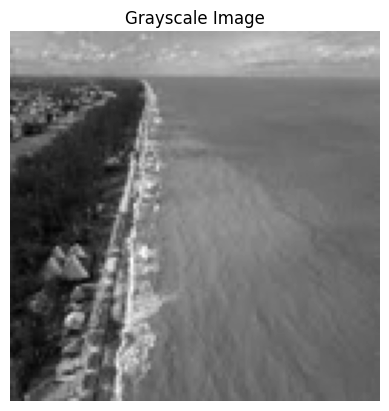

In [6]:
import matplotlib.pyplot as plt

# Hiển thị ma trận Grayscale dưới dạng ảnh
plt.imshow(grayscale, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()